In [13]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [3]:
from lib.relations import RELATIONS_TABLE

PROMPT_INTRO = f"""\
Your task is to determine the semantic relation between two nodes A and B.
You will be provided with nodes A and B.

Here is a list of all of the possible semantic relations:
{RELATIONS_TABLE}
"""

PROMPT_OUTRO = """\
Please respond with the top 5 ranked Relation URIs between A and B based on their likelihood.
The most likely relation should come first. List only the top 5.
Do not order the list; simply provide a new Relation URI on each line.

Example:
/r/[RELATION_A]
/r/[RELATION_B]
/r/[RELATION_C]
"""


def create_prompt(node_a, node_b):
    return f"""\
{PROMPT_INTRO}

---

Node A: {node_a}
Node B: {node_b}

---

{PROMPT_OUTRO}
"""

In [4]:
from lib.ndcg import ndcg_at_k
from lib.openai import ask_gpt


def process_pair(relation, pair):
    node_a, node_b = pair

    prompt = create_prompt(node_a, node_b)
    response_list = ask_gpt(prompt).split("\n")[:5]  # Get only the top 5 relations as a list
    correct_index = response_list.index(relation) if relation in response_list else len(response_list)

    # Create relevance scores where the correct relation has the highest score
    relevance_scores = [1 if idx == correct_index else 0 for idx in range(len(response_list))]
    ndcg_score = ndcg_at_k(relevance_scores)

    result = {
        "pair": pair,
        "actual_relation": relation,
        "predicted_relations": response_list,
        "ndcg_score": ndcg_score
    }

    return result

In [5]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from lib.sql import create_connection
from lib.sql.queries import get_random_english_concepts_connected_by_relation
from lib.relations import RELATIONS

pairs = []
actual_relations = []
predicted_relations = []
ndcg_scores = []

conn = create_connection()

for relation in RELATIONS:
    print(f"Testing relation: {relation}")
    test_pairs = get_random_english_concepts_connected_by_relation(conn, relation, 100)

    with ThreadPoolExecutor() as executor:
        futures = []

        for pair in test_pairs:
            futures.append(executor.submit(process_pair, relation, pair))

        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            pairs.append(result["pair"])
            actual_relations.append(result["actual_relation"])
            predicted_relations.append(result["predicted_relations"])
            ndcg_scores.append(result["ndcg_score"])

Testing relation: /r/RelatedTo


100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


Testing relation: /r/FormOf


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


Testing relation: /r/IsA


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


Testing relation: /r/PartOf


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Testing relation: /r/HasA


100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


Testing relation: /r/UsedFor


100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Testing relation: /r/CapableOf


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Testing relation: /r/AtLocation


100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


Testing relation: /r/Causes


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Testing relation: /r/HasSubevent


100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Testing relation: /r/HasFirstSubevent


100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


Testing relation: /r/HasLastSubevent


100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


Testing relation: /r/HasPrerequisite


100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Testing relation: /r/HasProperty


100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


Testing relation: /r/MotivatedByGoal


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Testing relation: /r/Desires


100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


Testing relation: /r/CreatedBy


100%|██████████| 100/100 [00:05<00:00, 19.89it/s]


Testing relation: /r/Synonym


100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


Testing relation: /r/Antonym


100%|██████████| 100/100 [00:04<00:00, 20.48it/s]


Testing relation: /r/DistinctFrom


100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


Testing relation: /r/DerivedFrom


100%|██████████| 100/100 [00:04<00:00, 21.15it/s]


Testing relation: /r/DefinedAs


100%|██████████| 100/100 [00:04<00:00, 20.70it/s]


Testing relation: /r/HasContext


100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


Testing relation: /r/SimilarTo


100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


Testing relation: /r/EtymologicallyRelatedTo


100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


Testing relation: /r/CausesDesire


100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


Testing relation: /r/MadeOf


100%|██████████| 100/100 [00:04<00:00, 20.25it/s]


Testing relation: /r/ReceivesAction


100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


In [9]:
from lib.json import save_to_json_file

save_to_json_file("inputs/unique_pairs", {"pairs": pairs, "actual_relations": actual_relations})
save_to_json_file("results/unique_pairs", {"predicted_relations": predicted_relations, "ndcg_scores": ndcg_scores})

Matplotlib is building the font cache; this may take a moment.


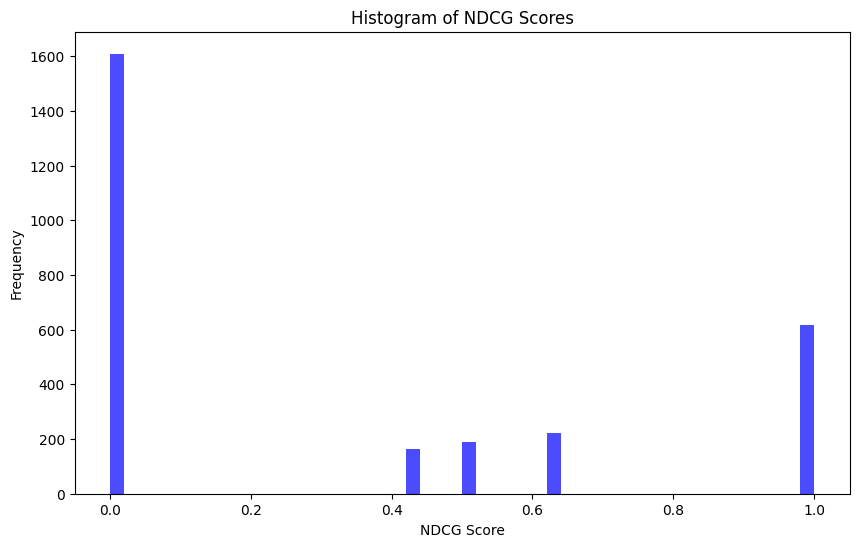

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(ndcg_scores, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of NDCG Scores')
plt.xlabel('NDCG Score')
plt.ylabel('Frequency')
plt.show()

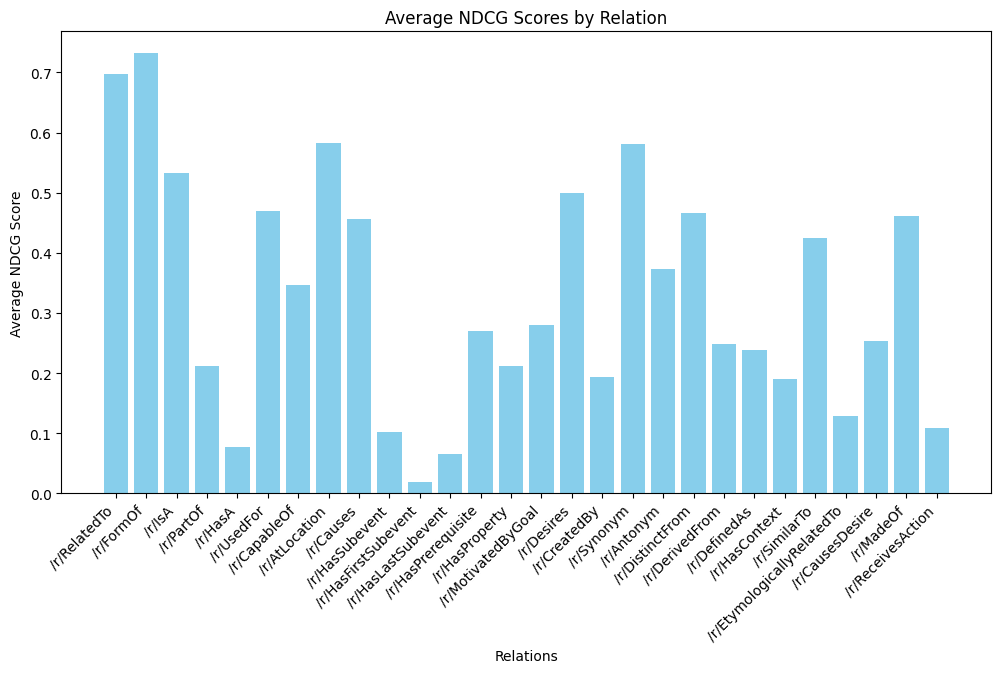

In [12]:
from collections import defaultdict

# Assuming actual_relations is a list of relation names and ndcg_scores is a list of corresponding scores
relation_scores = defaultdict(list)

for relation, score in zip(actual_relations, ndcg_scores):
    relation_scores[relation].append(score)

# Calculate the average NDCG score for each relation
average_scores = {relation: sum(scores) / len(scores) for relation, scores in relation_scores.items()}

# Preparing data
relations = list(average_scores.keys())
scores = [average_scores[relation] for relation in relations]

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(relations, scores, color='skyblue')
plt.xlabel('Relations')
plt.ylabel('Average NDCG Score')
plt.title('Average NDCG Scores by Relation')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()